# Setup


## Jupyter extensions


In [2]:
%load_ext autoreload
%autoreload 2
%cd ..
%pwd

/home/oli/Research/interpreting-rewards/code


'/home/oli/Research/interpreting-rewards/code'

In [3]:
#start by adding parent directory...
import os
import sys
import inspect

from matplotlib import pyplot as plt

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(-1, parentdir) 
# Now build environment
# import numpy as np
import torch
import numpy
import primitives as prim
from environs import GridWorld
from utils import broadcompress

GW = GridWorld.make(11,8, noise=0.1)


# R0pt.require_grad()

# Sanity Checks

## A Demonstration of $\partial_R \pi^*_R$
Compute the directional derivitives of $\pi^*$ for the reward $R$ in for each of the constant policy actions.

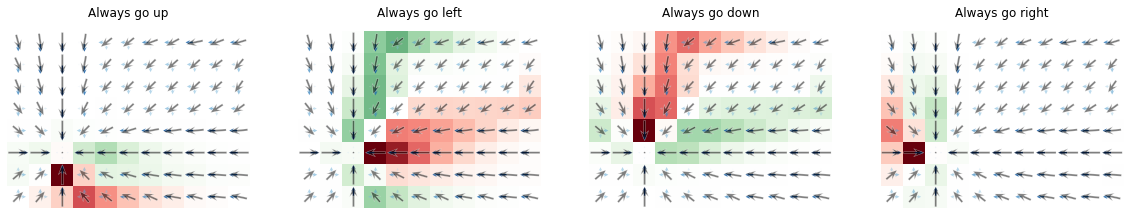

In [53]:

fig, ax = plt.subplots(1, len(GW.A), sharex=True, sharey=True, figsize=(20,5))
for ia, (a, axa) in enumerate(zip(GW.A.ordered, ax)):

    R0pt = torch.zeros(GW.Sshape)
    R0pt[21] = 1
    # R0pt[44] = 1
    R0pt.requires_grad = True

    piopt = prim.fwd(GW, R0pt, 0.99, temp=0.001, val_iters=100)

    always_do_a = torch.zeros(GW.SAshape)
    always_do_a[:, ia, :] = 1

    axa.set_title("Always go "+a)
    piopt.backward(always_do_a)
    GW.draw(states=R0pt.grad, policy=piopt, ax=axa)

    del R0pt

#### Observations: 

**Rationalization of the asymmetry.**  Adding a small amount of reward above the desired spot won't keep the optimal policy from going down, but a negative reward underneath will ensure that the adjacent squares should go up rather than randomizing 50/50. 


Prediction: we can iterate this to get a desired policy, doing IRL 


## Demonstrating derivative of value with respect to reward

In [30]:
vstar = prim.value_iter(GW, R0pt, 0.99, temperature=0.01)
vstar.requires_grad

True

# MCE-IRL with Torch

In [134]:

def torch_MCE_IRL(env, desired_policy, gamma, iters=100, loss_fn='-sim'):
    # the parameters are the rewards.
    # start with the zero reward
    R = torch.zeros(env.SAshape, requires_grad = True)

    # optimizer = torch.optim.SGD([R], lr=0.1)
    optimizer = torch.optim.Adam([R], lr=0.01)
    losses = []

    for it in range(iters):
        optimizer.zero_grad()
        opt_policy = prim.fwd(GW, R, gamma, temp=0.001, val_iters=100)

        ## negative similarity loss
        if loss_fn == '-sim':
            loss = (- desired_policy * opt_policy).sum()
        ## KL DIV
        if loss_fn == 'kl':
            loss = (desired_policy * torch.where(desired_policy==0, 0., torch.log(torch.div(desired_policy, opt_policy)))).sum()
        if loss_fn == 'sq':
            loss = ((desired_policy - opt_policy)**2).sum()
        loss.backward()
        losses.append(loss.detach())

        optimizer.step()

    torch_MCE_IRL.losses = losses
    return R.detach()

## IRL for a deterministic policy

MSE:  tensor(3.8996e-08, dtype=torch.float64)


Text(0.5, 1.0, 'traininc curve: negative similarity loss')

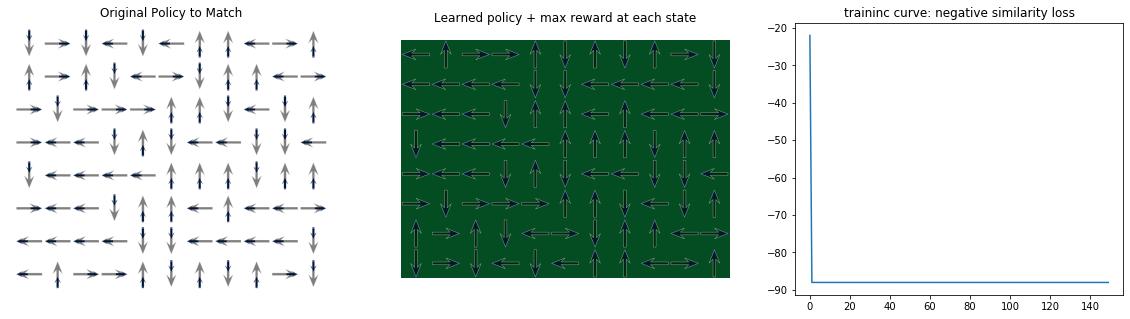

In [135]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

pi = GW.random_policy(det=True)
GW.draw(policy=pi, ax=ax1)
R = torch_MCE_IRL(GW, pi, 0.999, iters=150, loss_fn='-sim')
piopt = prim.fwd(GW, R, 0.99, temp=0.01, val_iters=100)
GW.draw(policy=piopt, states=R.numpy().max(axis=1), ax=ax2)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(torch_MCE_IRL.losses)

ax1.set_title("Original Policy to Match")
ax2.set_title("Learned policy + max reward at each state")
ax3.set_title("traininc curve: negative similarity loss")

## IRL for The optimal policy for the point reward

MSE:  tensor(25.0988, dtype=torch.float64)


Text(0.5, 1.0, 'traininc curve: -sim loss')

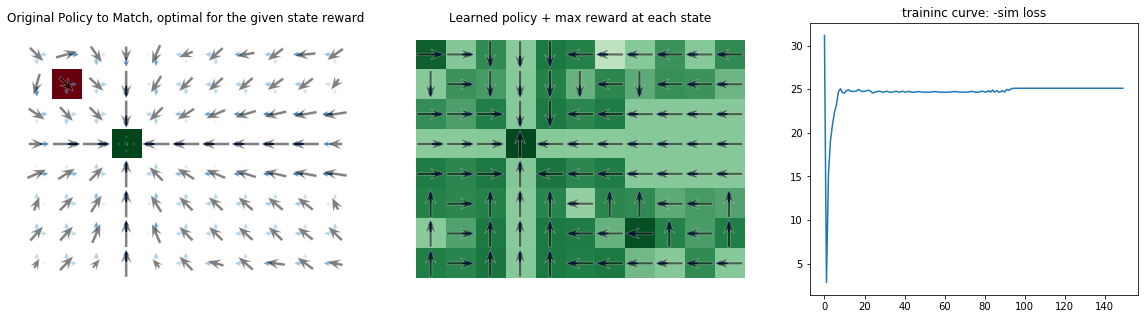

In [136]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))


R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax1)
R = torch_MCE_IRL(GW, pi, 0.999, iters=150, loss_fn='sq')
piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=piopt, states=R.numpy().max(axis=1), ax=ax2)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(torch_MCE_IRL.losses)
# ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

ax1.set_title("Original Policy to Match, optimal for the given state reward")
ax2.set_title("Learned policy + max reward at each state")
ax3.set_title("traininc curve: -sim loss")

Let's try the entropy-regularized version of that.

MSE:  tensor(18.0085, dtype=torch.float64)


Text(0.5, 1.0, 'traininc curve: -sim loss')

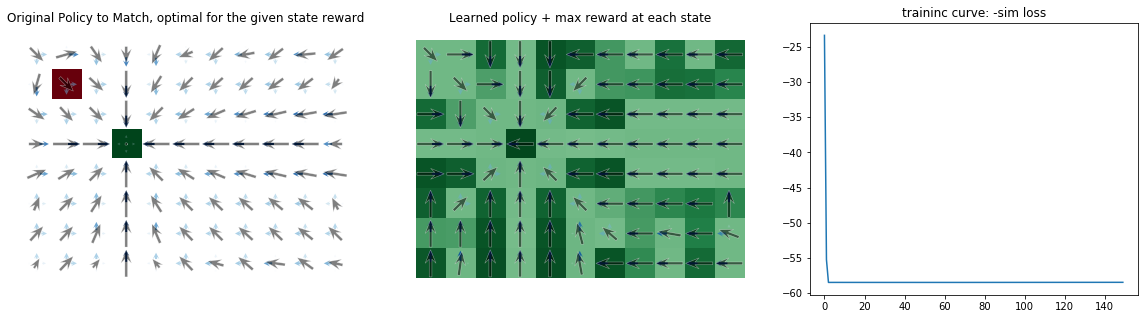

In [21]:
def entropy_regularized_torch_MCE_IRL(env, desired_policy, gamma, iters=100, loss_fn='-sim'):
    # the parameters are the rewards.
    # start with the zero reward
    R = torch.zeros(env.SAshape, requires_grad = True)

    optimizer = torch.optim.Adam([R], lr=0.01)
    losses = []

    for it in range(iters):
        optimizer.zero_grad()
        opt_policy = prim.fwd(GW, R, gamma, temp=0.001, val_iters=100)

        ## negative similarity loss
        if loss_fn == '-sim':
            loss = (- desired_policy * opt_policy).sum()
        ## KL DIV
        if loss_fn == 'kl':
            loss = (desired_policy * torch.log(torch.div(desired_policy, opt_policy))).sum()
        if loss_fn == 'sq':
            loss = ((desired_policy - opt_policy)**2).sum()
        loss += torch.where(opt_policy==0, 0., opt_policy*torch.log(torch.where(opt_policy==0, 1., opt_policy))).sum() / GW.nS
        loss.backward()
        losses.append(loss.detach())

        optimizer.step()

    entropy_regularized_torch_MCE_IRL.losses = losses
    return R.detach()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax1)
R = entropy_regularized_torch_MCE_IRL(GW, pi, 0.999, iters=150, loss_fn='-sim')
piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=piopt, states=R.numpy().max(axis=1), ax=ax2)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(entropy_regularized_torch_MCE_IRL.losses)
# ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

ax1.set_title("Original Policy to Match, optimal for the given state reward")
ax2.set_title("Learned policy + max reward at each state")
ax3.set_title("traininc curve: -sim loss")

# Regularized IRL

MSE:  tensor(26.6522, dtype=torch.float64)


Text(0.5, 1.0, 'traininc curve: -sim loss')

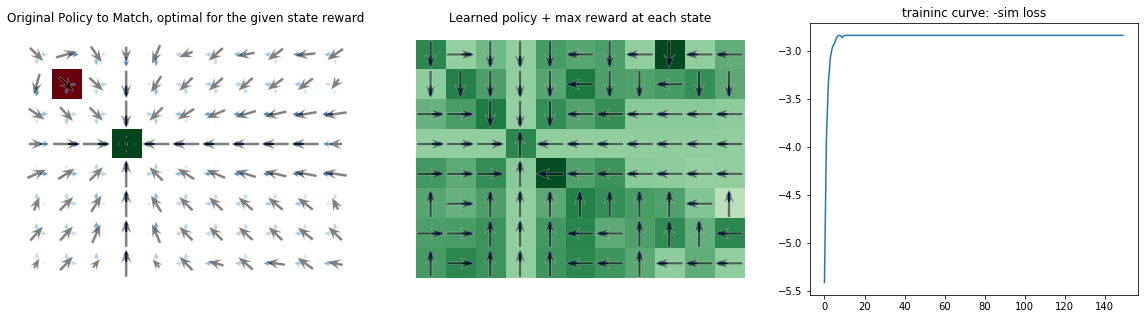

In [23]:
def regularized_torch_IRL(env, desired_policy, γ, iters=100):
    # the parameters are the rewards.
    # start with the zero reward
    R = torch.zeros(env.SAshape, requires_grad = True)

    optimizer = torch.optim.Adam([R], lr=0.01)
    losses = []
    
    for it in range(iters):
        optimizer.zero_grad()
        # V = prim.value_iter(GW, R, γ, 100, temperature=0.001)
        # opt_policy = prim.best_policy(GW, R, V, γ, temperature=0.001)
        opt_policy = prim.fwd(GW, R, γ, val_iters=100, temp=0.001)

        # dp = desired_policy
        # kl = (dp * torch.where(dp==0, 0., torch.log( torch.where(dp==0, 1., torch.div(dp, opt_policy+1e-8))))).sum()
        # mse = ((dp - opt_policy)**2).sum()
        loss = (- desired_policy * opt_policy).sum() / torch.sqrt( (desired_policy**2).sum() * (opt_policy**2).sum())

        ratio = 0.1
        γsmall = γ * ratio
        γbig = 1 + (γ - 1)*ratio
        policy_bigg = prim.fwd(GW, R, γbig, val_iters=100, temp=0.001)
        policy_smallg = prim.fwd(GW, R, γsmall, val_iters=100, temp=0.001)

        # loss = mse  
        loss -= 2 * (policy_bigg * policy_smallg).sum() / torch.sqrt( (policy_bigg**2).sum() * (policy_smallg**2).sum()) 
        # loss += torch.abs(R.sum(axis=1)).sum()
        loss += 2* torch.where(opt_policy==0, 0., opt_policy*torch.log(torch.where(opt_policy==0, 1., opt_policy))).sum() / GW.nS

        loss.backward()
        losses.append(loss.detach())

        optimizer.step()

    regularized_torch_IRL.losses = losses
    return R.detach()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))

R_dipole = torch.zeros(GW.Sshape)
R_dipole[GW.S.idx(('x3', 'y3'))] = 1
R_dipole[GW.S.idx(('x1', 'y1'))] = -1

pi = prim.fwd(GW, R_dipole, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=pi, states=broadcompress(R_dipole), ax=ax1)
R = regularized_torch_IRL(GW, pi, 0.999, iters=150)
piopt = prim.fwd(GW, R, 0.999, temp=0.001, val_iters=100)
GW.draw(policy=piopt, states=R.numpy().max(axis=1), ax=ax2)

print("MSE: ", ((piopt - pi)**2).sum() )

ax3.plot(regularized_torch_IRL.losses)
# ax3.semilogy(torch_MCE_IRL.losses - numpy.min(torch_MCE_IRL.losses)+1)

ax1.set_title("Original Policy to Match, optimal for the given state reward")
ax2.set_title("Learned policy + max reward at each state")
ax3.set_title("traininc curve: -sim loss")

In [1]:
plt

NameError: name 'plt' is not defined